# Chapter 8. Using convolutions to generalize

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import time
import datetime

from torchvision import datasets
from torchvision import transforms

## Data

In [2]:
model_path = "/Users/mattfeng/365-days-of-ml/saved_models"
data_path = "/Volumes/OXYTOCIN/datasets/cifar10"
mean = (0.4913996458053589, 0.48215845227241516, 0.44653093814849854)
std = (0.24703224003314972, 0.24348513782024384, 0.26158785820007324)

# building a dataset using a subset of cifar10
transformed_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

transformed_cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

label_map = {0: 0, 2: 1} # cifar10 -> cifar2
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in {0, 2}]
cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in {0, 2}]

## Convolutions

In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3) # 3 input channels, 16 output channels, 3x3 kernel
print(conv)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))


In [4]:
print(conv.weight.shape, conv.bias.shape)
# 16 filters, each with input 3x3x3 (channel, kernel width, kernel height)
# 1 bias per filter

torch.Size([16, 3, 3, 3]) torch.Size([16])


In [5]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # need a dimension for batches
print(img.unsqueeze(0).shape, output.shape)

torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


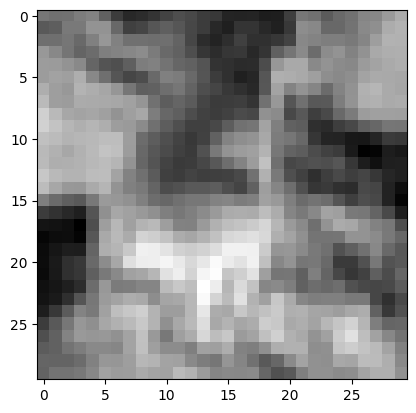

In [6]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

### Padding

In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3 input channels, 16 output channels, 3x3 kernel
print(conv)

img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # need a dimension for batches
print(img.unsqueeze(0).shape, output.shape)


Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 32, 32])


### Manual filters

#### Blur

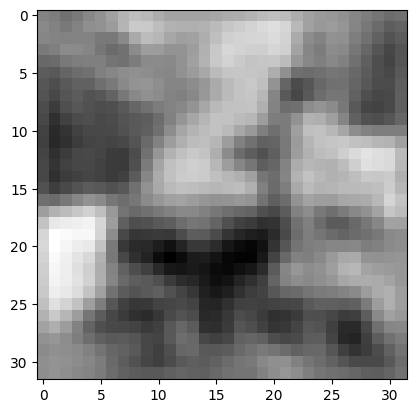

In [8]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3 input channels, 16 output channels, 3x3 kernel

with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

#### Vertical edge detector

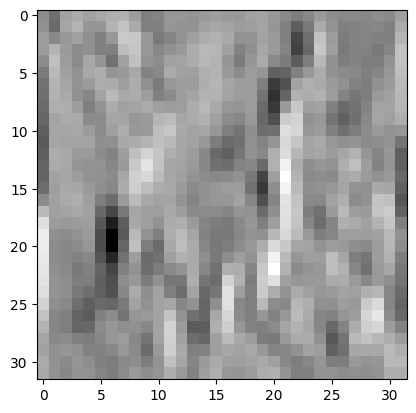

In [9]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3 input channels, 16 output channels, 3x3 kernel

with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = torch.tensor([[-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0]])

img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

### `MaxPool` Max pooling

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 16, 16])


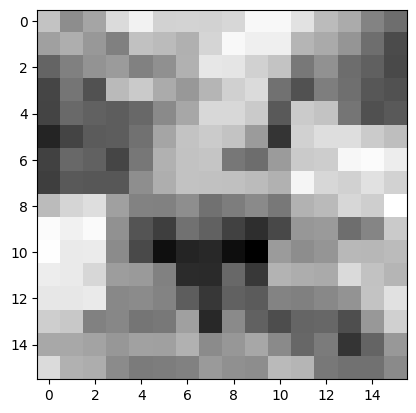

In [10]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

print(img.unsqueeze(0).shape, output.shape)
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

### Combining `Conv2d` and  `MaxPool2d`

In [11]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), # out (16, 32, 32)
    nn.Tanh(),
    nn.MaxPool2d(2),                            # out (16, 16, 16)
    nn.Conv2d(16, 8, kernel_size=3, padding=1), # out (8, 16, 16)
    nn.Tanh(),
    nn.MaxPool2d(2),                            # out (8, 8, 8)
    # need a flatten operation here
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [12]:
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


## Subclassing `nn.Module`

In [13]:
class Net(nn.Module):
    # all parameters must be defined in __init__
    # for PyTorch to track them (when we call Module.parameters())
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # out (16, 32, 32)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)                            # out (16, 16, 16)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # out (8, 16, 16)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)                            # out (8, 8, 8)
        
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # reshape
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [14]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


## Functional API

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
model = Net()

img, _ = cifar2[0]
model(img.unsqueeze(0))

tensor([[0.1083, 0.1597]], grad_fn=<AddmmBackward0>)

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, device="cpu"):
    prev_devices = [d.device for d in model.parameters()]
    
    model.to(device=device)
    
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader) # average loss per batch
                ))
        
    for param, dev in zip(model.parameters(), prev_devices):
        param.to(device=dev)

In [18]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [19]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

start = time.time()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device="mps"
)
end = time.time()

print("training took {:.4f} seconds".format(end - start))

2023-01-16 01:12:32.821070 Epoch 1, Training loss 0.6040439936006146
2023-01-16 01:12:44.022205 Epoch 10, Training loss 0.34178083926249464
2023-01-16 01:12:56.428469 Epoch 20, Training loss 0.3045279536467449
2023-01-16 01:13:08.701769 Epoch 30, Training loss 0.2803690834030224
2023-01-16 01:13:21.079340 Epoch 40, Training loss 0.25604358941886074
2023-01-16 01:13:33.660150 Epoch 50, Training loss 0.23974208552746257
2023-01-16 01:13:47.253920 Epoch 60, Training loss 0.2211893314293995
2023-01-16 01:14:00.512844 Epoch 70, Training loss 0.20401476100561725
2023-01-16 01:14:13.764871 Epoch 80, Training loss 0.18988330799872707
2023-01-16 01:14:26.342596 Epoch 90, Training loss 0.1751278194414962
2023-01-16 01:14:39.081647 Epoch 100, Training loss 0.16077537818034743
training took 130.3088 seconds


### Measuring accuracy

In [20]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader, device="cpu"):
    prev_devices = [d.device for d in model.parameters()]
    
    model.to(device=device)
    
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # get index of highest prediction
                total += labels.shape[0] # batch is zeroth dimension
                correct += int((predicted == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name, correct / total))
    
    for param, dev in zip(model.parameters(), prev_devices):
        param.to(device=dev)

validate(model, train_loader, val_loader, "mps")

Accuracy train: 0.92
Accuracy val: 0.88


### Saving and loading models

In [21]:
torch.save(model.state_dict(), f"{model_path}/birds_vs_airplanes.pt")

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(f"{model_path}/birds_vs_airplanes.pt", map_location=device))

<All keys matched successfully>

In [23]:
torch.cuda.is_available()

False

In [24]:
torch.backends.mps.is_available()

True

### Training on other backends

In [25]:
for device in ["cpu", "mps"]:
    model = Net()
    optimizer = optim.SGD(model.parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    
    start = time.time()
    training_loop(
        n_epochs=100,
        optimizer=optimizer,
        model=model,
        loss_fn=loss_fn,
        train_loader=train_loader,
        device=device
    )
    end = time.time()
    print("training on {} took {:.4f} seconds".format(device, end - start))

2023-01-16 01:14:44.019763 Epoch 1, Training loss 0.5779705497489613
2023-01-16 01:15:16.335573 Epoch 10, Training loss 0.33777073614156927
2023-01-16 01:15:51.902763 Epoch 20, Training loss 0.3048663138394143
2023-01-16 01:16:27.827766 Epoch 30, Training loss 0.27747549239996894
2023-01-16 01:17:04.705622 Epoch 40, Training loss 0.2545934834867526
2023-01-16 01:17:44.210416 Epoch 50, Training loss 0.23486944411400776
2023-01-16 01:18:26.167187 Epoch 60, Training loss 0.21788703280079896
2023-01-16 01:19:02.556921 Epoch 70, Training loss 0.20266271861875132
2023-01-16 01:19:38.321343 Epoch 80, Training loss 0.1885809520627283
2023-01-16 01:20:13.141071 Epoch 90, Training loss 0.1751902179353556
2023-01-16 01:20:48.274254 Epoch 100, Training loss 0.16204459580836023
training on cpu took 368.0538 seconds
2023-01-16 01:20:49.568465 Epoch 1, Training loss 0.5998649790788152
2023-01-16 01:21:00.495547 Epoch 10, Training loss 0.33681364006297604
2023-01-16 01:21:12.925127 Epoch 20, Training 

## Model design

### Regularization

In [26]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.nchans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### Batch normalization

In [27]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.n_chans2 = n_chans2 = n_chans1 // 2
        
        self.conv = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        
        
        self.conv2 = nn.Conv2d(n_chans1, n_chans2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans2)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans2)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### Residual networks

In [28]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # convolution now learns residual
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [29]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [30]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(ResBlock(n_chans=n_chans1) for _ in range(n_blocks))
        )
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    